## from tools import loadZarrArrays, getCohorts, log, get_colour_dict
from pathlib import Path
import numpy as np
import pandas as pd
import allel
import dask.array as da
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

### PBS Scans

In [2]:
# Garuds Selection Scans # 
chrom = "X" #snakemake.wildcards['chrom']
windowSize = 1200 # snakemake.params['windowSize']
windowStep = 600 #snakemake.params['windowStep']
genotypePath = f"../../resources/snp_genotypes/all/1244-VO-GH-YAWSON-VMF00149/{chrom}/calldata/GT" #snakemake.input['genotypes'] if stat in ['G12', 'G123'] else []
positionsPath = f"../../resources/snp_genotypes/all/sites/{chrom}/variants/POS/"    #snakemake.input['positions']
siteFilterPath = f"../../resources/site_filters/dt_20200416/gamb_colu/{chrom}/variants/filter_pass/"

Which samples to use as outgroups? lets go with Mali 2004 - great because we have both gambiae and coluzzii, and little selection from insecticides.

In [3]:
ag3meta = pd.read_csv("/home/sanj/ag1000g/data/phase3/Ag1000g.phase3.manifest.full.tsv", sep="\t")
ag3meta = ag3meta.query("year == '2004'")

pd.crosstab(ag3meta['country'] , ag3meta['species_gambiae_coluzzii'])

species_gambiae_coluzzii,arabiensis,coluzzii,gambiae
country,,,
Burkina Faso,0,0,13
Mali,2,36,33
Mozambique,0,0,71


#### Load outgroups

In [4]:
Mali2004Meta = pd.read_csv("/home/sanj/ag1000g/data/phase3/metadata/general/AG1000G-ML-B/samples.meta.csv")
species = pd.read_csv("/home/sanj/ag1000g/data/phase3/metadata/species_calls_20200422/AG1000G-ML-B/samples.species_aim.csv")

Mali2004Meta = Mali2004Meta.merge(species)

outgroupPath = f"/home/sanj/ag1000g/data/phase3/snp_genotypes/all/AG1000G-ML-B/{chrom}/calldata/GT/"

#### Load metadata and arrays

In [5]:
# Read metadata 
metadata = pd.read_csv("../../resources/metadata/samples.meta.spp.csv")   #snakemake.params['metadata'], sep=",")
metadata['location'] = metadata['location'].str.split(".").str.get(0)

# Load arrays
snps, pos = loadZarrArrays(genotypePath, positionsPath, siteFilterPath=siteFilterPath, haplotypes=False)

In [12]:
snpsOutgroup, pos = loadZarrArrays(outgroupPath, positionsPath, siteFilterPath=siteFilterPath, haplotypes=False)


snpsOutgroupDict = {}

for sp in ['gambiae', 'coluzzii']:
    sp_bool = Mali2004Meta['species_gambiae_coluzzii'] == sp
    snpsOutgroupDict[sp] =  snpsOutgroup.compress(sp_bool, axis=1)

Make dummy phenotypes...

In [108]:
def getCohorts(metadata, columns=['species_gambiae_coluzzii', 'location'], comparatorColumn=None, minPopSize=15, colourVar='species_gambiae_coluzzii'):

    """
    This function takes a metadata sheet, and given columns, will return a pandas dataframe which contains a row
    for each cohort in the metadata, including cohort indices in the data, and strings for plotting, saving, and differnt colours
    for the colourVar column.
    """
    
    # subset metadata dataFrame and find combinations of variables with more than minPopSize individuals
    cohorts = metadata[columns]
    cohorts = cohorts.groupby(columns).size().reset_index().rename(columns={0:'size'})
    cohorts = cohorts[cohorts['size'] > minPopSize][columns]
    
    if comparatorColumn != None: 
        columns.remove(comparatorColumn)
    
    idxs = []
    for _, row in cohorts.iterrows():   
        # create the pandas metadata query for each cohort
        mycohortQuery = " & ".join([col + " == " + "'" + row.astype(str)[col] + "'" for col in cohorts.columns])
        # get indices of individuals in each cohort
        idxs.append(metadata.query(mycohortQuery).index.tolist())
    
    cohorts['indices'] = idxs
    cohorts['cohortText'] = cohorts[columns].agg(' | '.join, axis=1)
    cohorts['cohortNoSpaceText'] = cohorts['cohortText'].str.replace("|", ".", regex=False).str.replace(" ", "",regex=False)
    colours = get_colour_dict(cohorts[colourVar], palette="Set1")
    cohorts['colour'] = cohorts[colourVar].map(colours)
    
    if comparatorColumn != None: 
        columns.extend(['cohortText', 'cohortNoSpaceText', 'colour'])
#        cohorts = cohorts.set_index(columns, append=False)
 #       cohorts.pivot(index=cohorts.index, columns='pheno', values='indices')
        cohorts = cohorts.pivot(index=columns, columns=comparatorColumn)
        return(cohorts.reset_index())
    
    return(cohorts.reset_index(drop=True))

In [109]:
phenos = ['dead', 'alive']
columns=['location', 'species_gambiae_coluzzii', 'pheno']
metadata['pheno'] = np.random.choice(phenos, size=len(metadata))

In [110]:
columns.extend(['cohortText', 'cohortNoSpaceText', 'colour'])

In [111]:
columns.remove('pheno')

In [127]:
cohorts = getCohorts(metadata, columns=['location', 'species_gambiae_coluzzii', 'pheno'])
cohorts.head(7)

,location,species_gambiae_coluzzii,pheno,indices,cohortText,cohortNoSpaceText,colour
0,Annorkrom,coluzzii,alive,"[79, 80, 85, 88, 89, 265, 266, 271, 274, 275, ...",Annorkrom | coluzzii | alive,Annorkrom.coluzzii.alive,#e41a1c
1,Annorkrom,coluzzii,dead,"[77, 81, 82, 83, 84, 86, 87, 90, 91, 267, 268,...",Annorkrom | coluzzii | dead,Annorkrom.coluzzii.dead,#e41a1c
2,Domenase,coluzzii,alive,"[122, 126, 127, 129, 133, 135, 139, 140, 141, ...",Domenase | coluzzii | alive,Domenase.coluzzii.alive,#e41a1c
3,Domenase,coluzzii,dead,"[123, 124, 125, 128, 130, 131, 132, 134, 136, ...",Domenase | coluzzii | dead,Domenase.coluzzii.dead,#e41a1c
4,Koniyaw,coluzzii,alive,"[28, 30, 32, 35, 36, 37, 184, 186, 187, 189, 1...",Koniyaw | coluzzii | alive,Koniyaw.coluzzii.alive,#e41a1c
5,New Edubiase,gambiae,alive,"[50, 56, 57, 59, 60, 217, 219, 221, 223, 224, ...",New Edubiase | gambiae | alive,NewEdubiase.gambiae.alive,#999999
6,Nkotumso,coluzzii,dead,"[111, 113, 115, 117, 118, 119, 120, 121, 307, ...",Nkotumso | coluzzii | dead,Nkotumso.coluzzii.dead,#e41a1c


In [135]:
cohorts['loc'] = cohorts['cohortNoSpaceText'].str.replace(".alive", "").str.replace(".dead", "")

In [136]:
cohorts.pivot('loc', 'pheno')

location            species_gambiae_coluzzii  \
pheno                       alive       dead                    alive   
loc                                                                     
Annorkrom.coluzzii      Annorkrom  Annorkrom                 coluzzii   
Domenase.coluzzii        Domenase   Domenase                 coluzzii   
Koniyaw.coluzzii          Koniyaw        NaN                 coluzzii   
NewEdubiase.gambiae  New Edubiase        NaN                  gambiae   
Nkotumso.coluzzii             NaN   Nkotumso                      NaN   
Odumto.coluzzii            Odumto        NaN                 coluzzii   
Pokukrom.coluzzii             NaN   Pokukrom                      NaN   

                               \
pheno                    dead   
loc                             
Annorkrom.coluzzii   coluzzii   
Domenase.coluzzii    coluzzii   
Koniyaw.coluzzii          NaN   
NewEdubiase.gambiae       NaN   
Nkotumso.coluzzii    coluzzii   
Odumto.coluzzii           NaN   
Pokukrom.coluzzii    coluzzii   

                                                               indices  \
pheno                                                            alive   
loc                                                                      
Annorkrom.coluzzii   [79, 80, 85, 88, 89, 265, 266, 271, 274, 275, ...   
Domenase.coluzzii    [122, 126, 127, 129, 133, 135, 139, 140, 141, ...   
Koniyaw.coluzzii     [28, 30, 32, 35, 36, 37, 184, 186, 187, 189, 1...   
NewEdubiase.gambiae  [50, 56, 57, 59, 60, 217, 219, 221, 223, 224, ...   
Nkotumso.coluzzii                                                  NaN   
Odumto.coluzzii      [7, 8, 165, 166, 167, 169, 170, 171, 172, 173,...   
Pokukrom.coluzzii                                                  NaN   

                                                                        \
pheno                                                             dead   
loc                                                                      
Annorkrom.coluzzii   [77, 81, 82, 83, 84, 86, 87, 90, 91, 267, 268,...   
Domenase.coluzzii    [123, 124, 125, 128, 130, 131, 132, 134, 136, ...   
Koniyaw.coluzzii                                                   NaN   
NewEdubiase.gambiae                                                NaN   
Nkotumso.coluzzii    [111, 113, 115, 117, 118, 119, 120, 121, 307, ...   
Odumto.coluzzii                                                    NaN   
Pokukrom.coluzzii    [100, 101, 102, 103, 106, 107, 109, 295, 296, ...   

                                         cohortText  \
pheno                                         alive   
loc                                                   
Annorkrom.coluzzii     Annorkrom | coluzzii | alive   
Domenase.coluzzii       Domenase | coluzzii | alive   
Koniyaw.coluzzii         Koniyaw | coluzzii | alive   
NewEdubiase.gambiae  New Edubiase | gambiae | alive   
Nkotumso.coluzzii                               NaN   
Odumto.coluzzii           Odumto | coluzzii | alive   
Pokukrom.coluzzii                               NaN   

                                                          cohortNoSpaceText  \
pheno                                       dead                      alive   
loc                                                                           
Annorkrom.coluzzii   Annorkrom | coluzzii | dead   Annorkrom.coluzzii.alive   
Domenase.coluzzii     Domenase | coluzzii | dead    Domenase.coluzzii.alive   
Koniyaw.coluzzii                             NaN     Koniyaw.coluzzii.alive   
NewEdubiase.gambiae                          NaN  NewEdubiase.gambiae.alive   
Nkotumso.coluzzii     Nkotumso | coluzzii | dead                        NaN   
Odumto.coluzzii                              NaN      Odumto.coluzzii.alive   
Pokukrom.coluzzii     Pokukrom | coluzzii | dead                        NaN   

                                               colour           
pheno                                   dead    alive     dead  
loc      

Need a good way of getting the values from the comparator column (we need to ensure alive is first...)

In [16]:
value1, value2 = metadata["pheno"].unique()

--------- Running PBS on ['Annorkrom | coluzzii'] | Chromosome X ----------
filter to biallelic segregating sites
compute input data for PBS
calculate PBS and plot figs


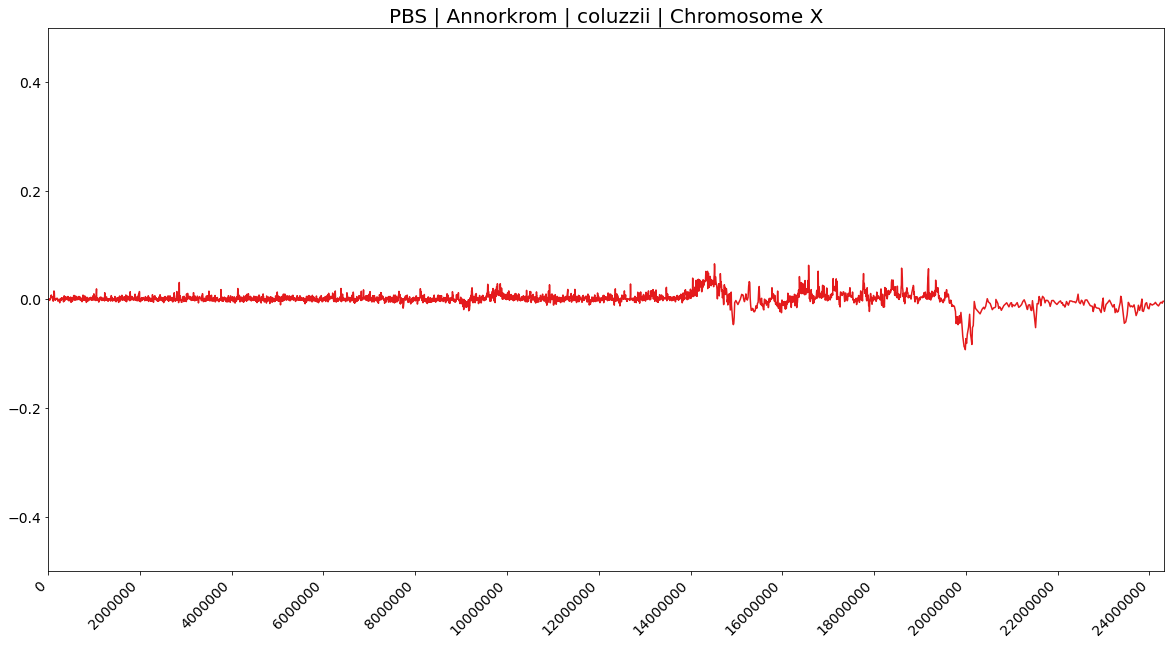

--------- Running PBS on ['Domenase | coluzzii'] | Chromosome X ----------
filter to biallelic segregating sites
compute input data for PBS
calculate PBS and plot figs


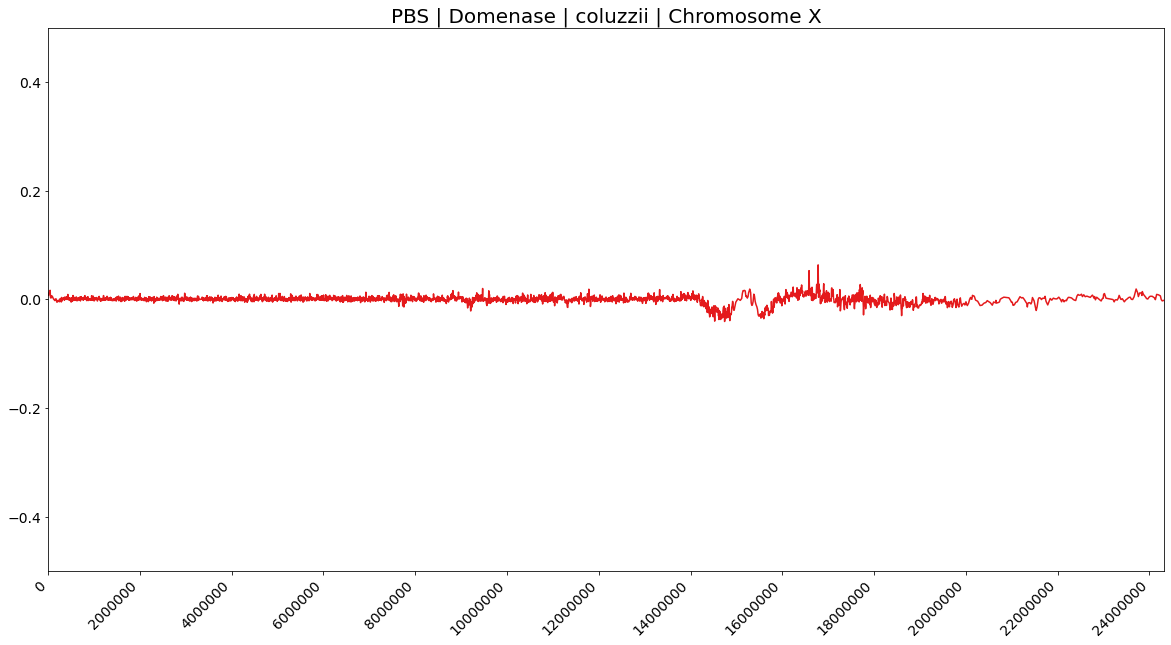

In [17]:
stat = 'PBS'
size = 1000
step = 600

# Loop through each cohort, manipulate genotype arrays and calculate chosen Garuds Statistic
for idx, cohort in cohorts[:2].iterrows():

    log(f"--------- Running {stat} on {cohort['cohortText'].to_list()} | Chromosome {chrom} ----------")
    log("filter to biallelic segregating sites")    
    species = cohort['species_gambiae_coluzzii'].to_list()[0]
    
    if len(cohort['indices']['alive']) < 15:
        continue
    elif len(cohort['indices']['dead']) < 15:
        continue

    ac_cohort = snps.count_alleles(max_allele=3).compute()
    # N.B., if going to use to_n_alt later, need to make sure sites are 
    # biallelic and one of the alleles is the reference allele
    ref_ac = ac_cohort[:, 0]
    loc_sites = ac_cohort.is_biallelic() & (ref_ac > 0)
    gt_seg = da.compress(loc_sites, snps, axis=0)
    pos_seg = da.compress(loc_sites, pos, axis=0)
    
    log(f"compute input data for {stat}")
    pos_seg = pos_seg.compute()
    
    ac_out = allel.GenotypeArray(da.compress(loc_sites, snpsOutgroupDict[species], axis=0)).count_alleles()
    ac_alive = allel.GenotypeArray(gt_seg).take(cohort['indices']['alive'], axis=1).count_alleles()
    ac_dead = allel.GenotypeArray(gt_seg).take(cohort['indices']['dead'], axis=1).count_alleles()
        
    assert ac_out.shape[0] == pos_seg.shape[0], "Arrays are the wrong length"
    assert ac_alive.shape[0] == pos_seg.shape[0], "Array alive/POS are the wrong length"
    assert ac_dead.shape[0] == pos_seg.shape[0], "Arrays dead/POS the wrong length"

    log("calculate PBS and plot figs")
    # calculate PBS and plot figs 
    pbsArray = allel.pbs(ac_alive, ac_dead, ac_out, 
                window_size=size, window_step=step, normed=True)
    midpoint = allel.moving_statistic(pos_seg, np.mean, size=size, step=step)
    
    windowedPlot(statName=stat, 
                cohortText = cohort['cohortText'].to_numpy()[0],
                cohortNoSpaceText= cohort['cohortNoSpaceText'].to_numpy()[0],
                values=pbsArray, 
                midpoints=midpoint,
                prefix=f"results/selection/{stat}", 
                chrom=chrom,
                colour=cohort['colour'].to_numpy()[0],
                ymin=-0.5,
                ymax=0.5,
                save=False)
    plt.show()